# MIDI-Trained Chord Recognition Model

## Data Preprocessing 

### 1. Load and Extract from midi_folder

In [50]:
import os
import json
import pretty_midi
import pandas as pd
import numpy as np
from collections import defaultdict
import mido
import io

# define chord type templates: intervals relative to root
CHORD_TEMPLATES = {
    "Major":         {0, 4, 7},
    "Minor":         {0, 3, 7},
    "Dominant 7th":  {0, 4, 7, 10},
    "Diminished":    {0, 3, 6},
    "Augmented":     {0, 4, 8},
}

PITCH_CLASS_NAMES = ['C', 'C#', 'D', 'D#', 'E', 'F',
                     'F#', 'G', 'G#', 'A', 'A#', 'B']

# normalize chord, removing octave transpositions 
def normalize_chord(chord_tuple):
    normalized_chord = {note % 12 for note in chord_tuple}  # keep only unique notes modulo 12
    return tuple(sorted(normalized_chord))

# identify and name chords 
def identify_named_chord(chord_tuple):
    if not chord_tuple:
        return "Unknown"

    pitch_classes = sorted({p % 12 for p in chord_tuple})
    for root in pitch_classes:
        transposed = sorted({(p - root) % 12 for p in pitch_classes})
        for label, template in CHORD_TEMPLATES.items():
            if set(transposed) == template:
                root_name = PITCH_CLASS_NAMES[root]
                return f"{root_name} {label}"
    return "Unknown"

# fixed mapping for chord vocab: all 12 roots * templates
def create_fixed_chord_vocab():
    ALL_CHORDS = [
        f"{pitch} {chord_type}"
        for pitch in PITCH_CLASS_NAMES
        for chord_type in CHORD_TEMPLATES.keys()
    ]
    chord_to_index = {chord: idx for idx, chord in enumerate(ALL_CHORDS)}
    return chord_to_index

# extract chord sequence
def midi_to_chord_sequence(midi_file, merge_threshold=0.3):
    #midi_data = pretty_midi.PrettyMIDI(midi_file)
    
    raw = mido.MidiFile(midi_file, clip=True)
    merged = mido.MidiFile() 
    merged.ticks_per_beat = raw.ticks_per_beat
    merged_track = mido.merge_tracks(raw.tracks)
    merged.tracks.append(merged_track)
    
    # dump to memory buffer
    buf = io.BytesIO()
    merged.save(file=buf)
    buf.seek(0)

    midi_data = pretty_midi.PrettyMIDI(buf)

    events = []
    # for each note, add two events: on/off
    for instrument in midi_data.instruments:
        if instrument.is_drum:
            continue
        for note in instrument.notes:
            events.append((note.start, 'on', note.pitch))
            events.append((note.end, 'off', note.pitch))
    
    events.sort(key=lambda x: x[0])

    active_notes = set()  # track notes that are in use
    chords = []  # final list
    previous_chord = None
    chord_start_time = None
    last_event_time = 0

    # if note is starting, add to active set
    # if note ending, remove it from active set
    for time, action, pitch in events:
        if action == 'on':
            active_notes.add(pitch)
        elif action == 'off':
            active_notes.discard(pitch)

        current_chord = normalize_chord(active_notes) if active_notes else None
        chord_label = identify_named_chord(current_chord) if current_chord else None

        # if chord changed
        if chord_label != previous_chord:
            if previous_chord is not None and chord_start_time is not None:
                if time - chord_start_time >= merge_threshold:
                    chords.append((round(chord_start_time, 3), round(time, 3), previous_chord))
            chord_start_time = time
            previous_chord = chord_label

        last_event_time = time

    # capture final chord if any
    if previous_chord is not None and chord_start_time is not None:
        chords.append((round(chord_start_time, 3), round(midi_data.get_end_time(), 3), previous_chord))

    return chords, midi_data

# timeframe-level feature extraction and align with chord labels
def extract_frame_level_data(chords, midi_data, chord_to_index, frame_hop=1):
    end_time = midi_data.get_end_time()
    frame_times = np.arange(0, end_time, frame_hop)

    chroma = midi_data.get_chroma(fs=int(1 / frame_hop))
    chroma = chroma.T  # transpose to shape (frames, 12)

    data = []

    for i, t in enumerate(frame_times):
        frame_feature = chroma[i] if i < len(chroma) else np.zeros(12)
        label = None
        for start, end, chord in chords:
            if start <= t < end:
                if chord in chord_to_index:
                    label = chord_to_index[chord]
                break
        if label is not None:
            data.append((t, frame_feature, label))
    return data


# process all midi files in the folder, save to CSV
def process_midi_folder(input_folder, chord_csv, frame_csv, frame_hop=1):
    chord_rows = []
    frame_rows = []
    chord_to_index = create_fixed_chord_vocab()

    for root, _, files in os.walk(input_folder):
        for fname in files:
            if not fname.lower().endswith(('.mid','.midi')): continue
            path = os.path.join(root, fname)
            rel = os.path.relpath(path, input_folder)
            try:
                chords, midi = midi_to_chord_sequence(path)
                # chord-level
                for st, ed, ch in chords:
                    chord_rows.append([rel, st, ed, ch])
                # frame-level
                frames = extract_frame_level_data(chords, midi, chord_to_index, frame_hop)
                for t, feat, lbl in frames:
                    frame_rows.append([rel, t, *feat, lbl])

            except Exception as e:
                print(f"[ERROR] {rel}: {e}")

    # save to csv
    chord_df = pd.DataFrame(chord_rows, columns=["filename","start_time","end_time","chord"])
    chord_df.to_csv(chord_csv, index=False)
    cols = [f"chroma_{i}" for i in range(12)]
    frame_df = pd.DataFrame(frame_rows, columns=["filename","time", *cols, "label"])
    frame_df.to_csv(frame_csv, index=False)

    print(f"✔ Saved chords to: {chord_csv}")
    print(f"✔ Saved frames to: {frame_csv}")
    return chord_to_index

### 2. Extract and Combine to csv file

In [51]:
# paths
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

folder_to_process = 'midi_folder' # test use; change to 'lakh-midi-clean' for actual experiments

base = os.path.basename(folder_to_process.rstrip(os.sep))
chord_csv = os.path.join(output_dir, f"chord_dataset.csv")
frame_csv = os.path.join(output_dir, f"timeframe_dataset.csv")
vocab_json = os.path.join(output_dir, f"chord_vocab.json")

chord_to_index = process_midi_folder(folder_to_process, chord_csv, frame_csv)

with open(vocab_json, 'w') as f:
    json.dump(chord_to_index, f, indent=2)

✔ Saved chords to: output/chord_dataset.csv
✔ Saved frames to: output/timeframe_dataset.csv


### 3. One-hot Encoding

In [52]:
# one-hot encoding 
import pandas as pd
import numpy as np
import os
import json

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

frame_csv_path = "output/timeframe_dataset.csv"
chord_vocab_path = "output/chord_vocab.json"
output_onehot_csv_path = os.path.join(output_dir, "timeframe_onehot.csv")


# load from JSON file
with open(chord_vocab_path, "r") as f:
    chord_to_index = json.load(f)

# reverse
chord_to_index = {str(k): v for k, v in chord_to_index.items()}


def one_hot_encode_labels(label_indices, num_classes):
    return np.eye(num_classes)[label_indices]

# load original timeframe-level dataset
df = pd.read_csv(frame_csv_path)

# get label col
label_indices = df["label"].astype(int).values

# one-hot encoding 
num_classes = len(chord_to_index)
one_hot = one_hot_encode_labels(label_indices, num_classes)

# create DataFrame 
one_hot_columns = [f"class_{i}" for i in range(num_classes)]
one_hot_df = pd.DataFrame(one_hot, columns=one_hot_columns)

# combine with filename + time 
minimal_df = df[["filename", "time"]].reset_index(drop=True)
result_df = pd.concat([minimal_df, one_hot_df], axis=1)

result_df.to_csv(output_onehot_csv_path, index=False)

print(f"One-hot encoded data saved to {output_onehot_csv_path}")

One-hot encoded data saved to output/timeframe_onehot.csv


## Baseline Model: SVM

In [22]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

frame_csv_path = "output/timeframe_dataset.csv"
df = pd.read_csv(frame_csv_path)

# split to train and test dataset
feature_cols = [f"chroma_{i}" for i in range(12)]
X = df[feature_cols].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RBF kernel 
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)

# print confusion metrics with zero_division fix
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.71      0.57       185
           1       0.50      0.38      0.43        24
           2       0.47      0.37      0.41        19
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.55      0.68      0.61        31
           6       0.75      0.46      0.57        13
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2
          10       0.59      0.74      0.66       133
          11       0.53      0.47      0.49        45
          12       0.57      0.29      0.38        14
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.69      0.74      0.71        65
          16       0.00      0.00      0.00         5
    

## Deep Learning Models

### Reorganize timing data

In [24]:
import torch

# auto-select device:
if torch.cuda.is_available():
    device = torch.device("cuda")
    backend = "CUDA"
elif getattr(torch.backends, "mps", None) is not None \
     and torch.backends.mps.is_available():
    device = torch.device("mps")
    backend = "MPS (Apple Silicon)"
else:
    device = torch.device("cpu")
    backend = "CPU"

print(f"Using device: {device}  |  backend: {backend}")

Using device: cpu  |  backend: CPU


In [25]:
import numpy as np
import pandas as pd

def build_sequence_tensor(
    frame_df: pd.DataFrame,
    seq_len: int,
    num_feat: int = 12,
    num_classes: int = 24,
    to_torch: bool = False,
    device: str | None = None,
):

    groups = frame_df.groupby("filename", sort=False)
    n_song = len(groups)

    X_seq = np.zeros((n_song, seq_len, num_feat), dtype=np.float32)
    y_seq = np.zeros((n_song, seq_len),        dtype=np.int64)

    for idx, (_, g) in enumerate(groups):
        g = g.sort_values("time")

        x = g[[f"chroma_{i}" for i in range(num_feat)]].to_numpy(dtype=np.float32)
        y = g["label"].to_numpy(dtype=np.int64)

        pad = max(seq_len - len(x), 0)
        X_seq[idx] = np.pad(x, ((0, pad), (0, 0)), mode="constant")[:seq_len]
        y_seq[idx] = np.pad(y, (0, pad), mode="constant")[:seq_len]

    # one-hot via NumPy (no TF)
    eye = np.eye(num_classes, dtype=np.float32)
    y_seq_ohe = eye[y_seq]                    # (N, seq_len, C)

    if to_torch:
        import torch
        X_seq      = torch.tensor(X_seq,      device=device)
        y_seq_ohe  = torch.tensor(y_seq_ohe,  device=device)

    return X_seq, y_seq_ohe

In [26]:
import json, pandas as pd, numpy as np, torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# load data
df = pd.read_csv("output/timeframe_dataset.csv")
num_classes = len(json.load(open("output/chord_vocab.json")))

X_seq, y_seq_ohe = build_sequence_tensor(
    frame_df     = df,
    seq_len      = 64,
    num_feat     = 12,
    num_classes  = num_classes,
    to_torch     = True,
    device       = device
)

# train / val split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_seq, y_seq_ohe,
    test_size   = 0.20,
    random_state= 42,
    shuffle     = True
)

y_tr_idx = y_tr.argmax(dim=-1)
y_te_idx = y_te.argmax(dim=-1)


batch_size = 16
train_dl = DataLoader(
    TensorDataset(X_tr.float(), y_tr_idx.long()),
    batch_size = batch_size,
    shuffle    = True
)
val_dl = DataLoader(
    TensorDataset(X_te.float(), y_te_idx.long()),
    batch_size = batch_size,
    shuffle    = False
)

seq_len  = X_tr.size(1)
num_feat = X_tr.size(2) 

## 1. CNN Model

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

# model
class ChromaCNN_Frame(nn.Module):
    def __init__(self, n_feat, n_class, hidden=128, p_drop=0.3):
        super().__init__()

        def same_conv(cin, cout, k, dil=1):
            pad = dil * (k - 1) // 2         # IMPORTANT
            return nn.Sequential(
                nn.Conv1d(cin, cout, k, padding=pad, dilation=dil),
                nn.BatchNorm1d(cout), nn.ReLU()
            )

        self.backbone = nn.Sequential(
            same_conv(n_feat, 64, 3, 1),
            same_conv(64, 128, 5, 2),                # pad=4
            same_conv(128, hidden, 7, 4),            # pad=12
            nn.Dropout(p_drop)
        )
        self.cls = nn.Conv1d(hidden, n_class, 1)

    def forward(self, x):             # (B, T, F)
        x = x.transpose(1, 2)         # (B, F, T)
        h = self.backbone(x)          # (B, hidden, T)
        y = self.cls(h).transpose(1, 2)
        return y                      # (B, T, C)


# init
cnn_model = ChromaCNN_Frame(num_feat, num_classes).to(device)
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

epochs, patience = 30, 3
best_loss, patience_ctr = np.inf, 0
os.makedirs("checkpoints", exist_ok=True)
best_ckpt = "checkpoints/best_cnn.pt"
last_ckpt = "checkpoints/last_cnn.pt"


In [28]:
# training loop
num_epochs = 20
for epoch in range(1, epochs + 1):
    cnn_model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = cnn_model(xb)
        loss   = criterion(logits.reshape(-1, num_classes), yb.reshape(-1))
        loss.backward()
        optimizer.step()

    # validation
    cnn_model.eval(); val_loss = 0.
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            loss = criterion(cnn_model(xb).reshape(-1, num_classes),
                             yb.reshape(-1))
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_dl.dataset)
    print(f"[CNN] Epoch {epoch:02d}  val_loss={val_loss:.4f}")
    torch.save(cnn_model.state_dict(), last_ckpt)

    if val_loss < best_loss:
        best_loss, patience_ctr = val_loss, 0
        torch.save(cnn_model.state_dict(), best_ckpt)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.\n"); break

cnn_model.load_state_dict(torch.load(best_ckpt, map_location=device))
print("✓ CNN training done!")



[CNN] Epoch 01  val_loss=2.7739
[CNN] Epoch 02  val_loss=1.8188
[CNN] Epoch 03  val_loss=1.5277
[CNN] Epoch 04  val_loss=1.3809
[CNN] Epoch 05  val_loss=1.3095
[CNN] Epoch 06  val_loss=1.2457
[CNN] Epoch 07  val_loss=1.1844
[CNN] Epoch 08  val_loss=1.1497
[CNN] Epoch 09  val_loss=1.1130
[CNN] Epoch 10  val_loss=1.0754
[CNN] Epoch 11  val_loss=1.0565
[CNN] Epoch 12  val_loss=1.0563
[CNN] Epoch 13  val_loss=1.0321
[CNN] Epoch 14  val_loss=1.0419
[CNN] Epoch 15  val_loss=1.0206
[CNN] Epoch 16  val_loss=1.0080
[CNN] Epoch 17  val_loss=1.0215
[CNN] Epoch 18  val_loss=1.0087
[CNN] Epoch 19  val_loss=1.0213
Early stopping.

✓ CNN training done!


In [29]:
# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np, torch

pad_id = num_classes
mask_pad = True               # =False not ignore padding

cnn_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)     # xb:(B,T,F)  yb:(B,T)
        logits = cnn_model(xb)                    # (B,T,C)
        preds  = logits.argmax(-1)                # (B,T)

        if mask_pad:
            valid = (yb != pad_id)
            all_preds.extend(preds[valid].cpu().numpy())
            all_labels.extend(yb[valid].cpu().numpy())
        else:
            all_preds.extend(preds.cpu().numpy().ravel())
            all_labels.extend(yb.cpu().numpy().ravel())


acc = accuracy_score(all_labels, all_preds)
print(f"Frame accuracy : {acc:.4f}\n")

print("Classification Report:")
print(classification_report(all_labels, all_preds, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))



Frame accuracy : 0.7475

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1516
           1       0.43      0.50      0.46         6
           2       0.00      0.00      0.00        16
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00        32
           7       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         3
          10       0.60      0.81      0.69       134
          11       0.76      0.33      0.46        58
          12       0.00      0.00      0.00         3
          15       0.32      0.55      0.41        20
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         1
          20       0.61      0.64      0.62       177
          21       0.16      0.17      0.16        18
          22       0.00      0.00      0.00         6
          25       0.55      0.69

## 2. RNN Model

In [30]:
import os, torch, numpy as np
from torch import nn

# define RNN model
class SimpleRNNModel(nn.Module):
    def __init__(self, n_feat, n_classes, hidden=64):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=n_feat,
            hidden_size=hidden,
            batch_first=True,
            nonlinearity="tanh"
        )
        self.fc = nn.Linear(hidden, n_classes)

    def forward(self, x):                 # x: (B, T, F)
        out, _ = self.rnn(x)              # (B, T, H)
        return self.fc(out)               # (B, T, C)

# init
rnn_model = SimpleRNNModel(num_feat, num_classes).to(device)
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)

epochs, patience = 30, 3
best_loss        = np.inf
patience_ctr     = 0

# checkpoint paths
os.makedirs("checkpoints", exist_ok=True)
best_ckpt = "checkpoints/best_rnn.pt"
last_ckpt = "checkpoints/last_rnn.pt"

# training loop
for epoch in range(1, epochs + 1):
    rnn_model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = rnn_model(xb)
        loss = criterion(logits.reshape(-1, num_classes), yb.reshape(-1))
        loss.backward()
        optimizer.step()

    # validation
    rnn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = rnn_model(xb)
            loss = criterion(logits.reshape(-1, num_classes), yb.reshape(-1))
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_dl.dataset)

    print(f"Epoch {epoch:02d}  val_loss={val_loss:.4f}")
    torch.save(rnn_model.state_dict(), last_ckpt)            # always save last

    if val_loss < best_loss:                                 # save best
        best_loss = val_loss
        patience_ctr = 0
        torch.save(rnn_model.state_dict(), best_ckpt)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.\n")
            break

# restore best
ckpt_to_load = best_ckpt if os.path.exists(best_ckpt) else last_ckpt
rnn_model.load_state_dict(torch.load(ckpt_to_load, map_location=device))
print(f"✓ RNN training done!")

Epoch 01  val_loss=3.6582
Epoch 02  val_loss=2.7802
Epoch 03  val_loss=1.9495
Epoch 04  val_loss=1.5609
Epoch 05  val_loss=1.4114
Epoch 06  val_loss=1.3318
Epoch 07  val_loss=1.2824
Epoch 08  val_loss=1.2484
Epoch 09  val_loss=1.2156
Epoch 10  val_loss=1.1895
Epoch 11  val_loss=1.1698
Epoch 12  val_loss=1.1528
Epoch 13  val_loss=1.1366
Epoch 14  val_loss=1.1202
Epoch 15  val_loss=1.1097
Epoch 16  val_loss=1.1011
Epoch 17  val_loss=1.0936
Epoch 18  val_loss=1.0857
Epoch 19  val_loss=1.0804
Epoch 20  val_loss=1.0783
Epoch 21  val_loss=1.0688
Epoch 22  val_loss=1.0648
Epoch 23  val_loss=1.0615
Epoch 24  val_loss=1.0547
Epoch 25  val_loss=1.0526
Epoch 26  val_loss=1.0482
Epoch 27  val_loss=1.0457
Epoch 28  val_loss=1.0437
Epoch 29  val_loss=1.0399
Epoch 30  val_loss=1.0366
✓ RNN training done!


## 3. BiLSTM Model

In [31]:
import os, torch, numpy as np
from torch import nn

# bidirectional LSTM
class BiLSTMModel(nn.Module):
    def __init__(self, n_feat, n_classes, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_feat,
            hidden_size=hidden,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden * 2, n_classes)

    def forward(self, x):                  # x: (B, T, F)
        out, _ = self.lstm(x)              # (B, T, 2H)
        out = self.fc(out)                 # (B, T, C)
        return out

# init
lstm_model = BiLSTMModel(num_feat, num_classes).to(device)
criterion   = nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

epochs, patience = 30, 3
best_loss        = np.inf
patience_ctr     = 0

# checkpoint directory
os.makedirs("checkpoints", exist_ok=True)
best_ckpt  = "checkpoints/best_lstm.pt"
last_ckpt  = "checkpoints/last_lstm.pt"

# training loop
for epoch in range(1, epochs + 1):
    lstm_model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = lstm_model(xb)
        loss   = criterion(logits.reshape(-1, num_classes),
                           yb.reshape(-1))
        loss.backward()
        optimizer.step()

    # validation
    lstm_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = lstm_model(xb)
            loss   = criterion(logits.reshape(-1, num_classes),
                               yb.reshape(-1))
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_dl.dataset)

    print(f"Epoch {epoch:02d}  val_loss={val_loss:.4f}")

    torch.save(lstm_model.state_dict(), last_ckpt)

    # save best & early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_ctr = 0
        torch.save(lstm_model.state_dict(), best_ckpt)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.\n")
            break

# load best
ckpt_to_load = best_ckpt if os.path.exists(best_ckpt) else last_ckpt
lstm_model.load_state_dict(torch.load(ckpt_to_load, map_location=device))
print(f"✓ LSTM training done!")


Epoch 01  val_loss=3.7798
Epoch 02  val_loss=3.1767
Epoch 03  val_loss=1.7809
Epoch 04  val_loss=1.4718
Epoch 05  val_loss=1.3504
Epoch 06  val_loss=1.2589
Epoch 07  val_loss=1.1930
Epoch 08  val_loss=1.1398
Epoch 09  val_loss=1.0997
Epoch 10  val_loss=1.0658
Epoch 11  val_loss=1.0401
Epoch 12  val_loss=1.0202
Epoch 13  val_loss=1.0030
Epoch 14  val_loss=0.9896
Epoch 15  val_loss=0.9754
Epoch 16  val_loss=0.9629
Epoch 17  val_loss=0.9532
Epoch 18  val_loss=0.9452
Epoch 19  val_loss=0.9372
Epoch 20  val_loss=0.9310
Epoch 21  val_loss=0.9261
Epoch 22  val_loss=0.9211
Epoch 23  val_loss=0.9175
Epoch 24  val_loss=0.9152
Epoch 25  val_loss=0.9093
Epoch 26  val_loss=0.9046
Epoch 27  val_loss=0.9046
Epoch 28  val_loss=0.9014
Epoch 29  val_loss=0.8988
Epoch 30  val_loss=0.8967
✓ LSTM training done!


## 4. Hybrid Model (CNN+BiLSTM)

In [32]:
import torch, torch.nn as nn
import numpy as np, os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


class CNN_BiLSTM(nn.Module):
    def __init__(self, n_feat, n_class,
                 cnn_hidden=128, lstm_hidden=64, p_drop=0.3):
        super().__init__()

        def same_conv(cin, out_channels, k, dil=1):
            pad = dil * (k - 1) // 2
            return nn.Sequential(
                nn.Conv1d(cin, out_channels, k, padding=pad, dilation=dil),
                nn.BatchNorm1d(out_channels), nn.ReLU()
            )

        # local convolution
        self.cnn = nn.Sequential(
            same_conv(n_feat, 64, 3, 1),
            same_conv(64,  cnn_hidden, 5, 1)
        )
        # long-term dependency
        self.lstm = nn.LSTM(cnn_hidden, lstm_hidden,
                            batch_first=True, bidirectional=True)
        self.drop = nn.Dropout(p_drop)
        self.fc   = nn.Linear(lstm_hidden * 2, n_class)

    def forward(self, x):              # x:(B,T,F)
        x = x.transpose(1, 2)          # (B,F,T)
        h = self.cnn(x).transpose(1, 2)# (B,T,Hc)  len = T
        o, _ = self.lstm(h)            # (B,T,2Hl)
        o = self.drop(o)
        return self.fc(o)              # (B,T,C)

pad_id        = num_classes            # 24
total_classes = num_classes + 1        # 25

hyb_model = CNN_BiLSTM(num_feat, total_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
optimizer = torch.optim.Adam(hyb_model.parameters(), lr=1e-3)

best_loss, wait = np.inf, 0
os.makedirs("checkpoints", exist_ok=True)
best_ckpt, last_ckpt = "checkpoints/best_hyb.pt", "checkpoints/last_hyb.pt"



In [33]:
# training loop
epochs, patience = 30, 3

for ep in range(1, epochs + 1):
    # train
    hyb_model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = hyb_model(xb)                             # (B,T,25)
        loss   = criterion(logits.reshape(-1, logits.size(-1)),
                           yb.reshape(-1))
        loss.backward(); optimizer.step()

    # val
    hyb_model.eval(); val_loss = 0.
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = hyb_model(xb)
            loss   = criterion(logits.reshape(-1, logits.size(-1)),
                               yb.reshape(-1))
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_dl.dataset)
    print(f"[HYB] Ep{ep:02d} val_loss={val_loss:.4f}")

    torch.save(hyb_model.state_dict(), last_ckpt)
    if val_loss < best_loss:
        best_loss, wait = val_loss, 0
        torch.save(hyb_model.state_dict(), best_ckpt)
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping."); break

hyb_model.load_state_dict(torch.load(best_ckpt, map_location=device))
print("✓ Hybrid CNN+BiLSTM training done!")



[HYB] Ep01 val_loss=2.7464
[HYB] Ep02 val_loss=1.6590
[HYB] Ep03 val_loss=1.5308
[HYB] Ep04 val_loss=1.4186
[HYB] Ep05 val_loss=1.2875
[HYB] Ep06 val_loss=1.2171
[HYB] Ep07 val_loss=1.1541
[HYB] Ep08 val_loss=1.1435
[HYB] Ep09 val_loss=1.0721
[HYB] Ep10 val_loss=1.0424
[HYB] Ep11 val_loss=1.0141
[HYB] Ep12 val_loss=0.9929
[HYB] Ep13 val_loss=0.9563
[HYB] Ep14 val_loss=0.9610
[HYB] Ep15 val_loss=0.9291
[HYB] Ep16 val_loss=0.9387
[HYB] Ep17 val_loss=0.9272
[HYB] Ep18 val_loss=0.9454
[HYB] Ep19 val_loss=0.9393
[HYB] Ep20 val_loss=0.9117
[HYB] Ep21 val_loss=0.9111
[HYB] Ep22 val_loss=0.9040
[HYB] Ep23 val_loss=0.8989
[HYB] Ep24 val_loss=0.8895
[HYB] Ep25 val_loss=0.9035
[HYB] Ep26 val_loss=0.8917
[HYB] Ep27 val_loss=0.8752
[HYB] Ep28 val_loss=0.8925
[HYB] Ep29 val_loss=0.8644
[HYB] Ep30 val_loss=0.8957
✓ Hybrid CNN+BiLSTM training done!


In [34]:
# evaluation
pad_id = num_classes
mask_pad = True

hyb_model.eval()
all_p, all_l = [], []

with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)
        preds  = hyb_model(xb).argmax(-1)          # (B,T)

        if mask_pad:
            valid = (yb != pad_id)
            all_p.extend(preds[valid].cpu().numpy())
            all_l.extend(yb[valid].cpu().numpy())
        else:
            all_p.extend(preds.cpu().numpy().ravel())
            all_l.extend(yb.cpu().numpy().ravel())

acc = accuracy_score(all_l, all_p)
print(f"Frame accuracy : {acc:.4f}\n")
print(classification_report(all_l, all_p, zero_division=0))
print(confusion_matrix(all_l, all_p))


Frame accuracy : 0.7787

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1516
           1       0.31      0.67      0.42         6
           2       0.00      0.00      0.00        16
           5       0.00      0.00      0.00         2
           6       0.50      0.03      0.06        32
           7       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         3
          10       0.59      0.84      0.69       134
          11       0.61      0.53      0.57        58
          12       0.00      0.00      0.00         3
          15       0.30      0.40      0.34        20
          16       0.00      0.00      0.00         3
          17       1.00      1.00      1.00         1
          20       0.62      0.81      0.70       177
          21       0.43      0.33      0.38        18
          22       0.00      0.00      0.00         6
          25       0.69      0.75      0.72       118
  

## Evaluation

In [43]:
import numpy as np, json, mir_eval, torch, pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# chord vocab
with open("output/chord_vocab.json") as f:
    chord_to_idx = json.load(f)
idx_to_chord = {int(v): k for k, v in chord_to_idx.items()}

MIREX_MAPPING = {
    "Major": "maj",
    "Minor": "min",
    "Dominant 7th": "7",
    "Diminished": "dim",
    "Augmented": "aug"
}

def ints_to_chords(int_arr):
    out = []
    for i in int_arr.flatten():
        txt = idx_to_chord.get(int(i), "N")
        if txt in ("Unknown", "N"):
            out.append("N"); continue
        try:
            root, qual = txt.split(" ", 1)
            out.append(f"{root}:{MIREX_MAPPING.get(qual,'maj')}")
        except ValueError:
            out.append("N")
    return out


In [44]:
def predict_np(model, X_np, batch=128):
    model.eval(); outs=[]
    with torch.no_grad():
        for i in range(0, len(X_np), batch):
            xb = torch.tensor(X_np[i:i+batch], dtype=torch.float32, device=device)
            logits = model(xb)                     # (B,T,C)
            outs.append(torch.softmax(logits, -1).cpu().numpy())
    return np.concatenate(outs, 0)                 # (N,T,C)


In [45]:
import numpy as np, torch, mir_eval

def evaluate_chord_predictions(name,
                               y_pred_prob,
                               y_true_ohe,
                               frame_rate: float = 1.0,
                               pad_id: int | None = None,
                               verbose=True):

    # ensure NumPy
    if torch.is_tensor(y_pred_prob):
        y_pred_prob = y_pred_prob.detach().cpu().numpy()
    if torch.is_tensor(y_true_ohe):
        y_true_ohe  = y_true_ohe.detach().cpu().numpy()

    # flatten class indices
    y_pred_int = y_pred_prob.argmax(-1).ravel()
    y_true_int = y_true_ohe.argmax(-1).ravel()

    # optional PAD filtering
    if pad_id is not None:
        mask = y_true_int != pad_id
        y_pred_int, y_true_int = y_pred_int[mask], y_true_int[mask]

    # convert to MIREX chord strings
    est_labels = ints_to_chords(y_pred_int)
    ref_labels = ints_to_chords(y_true_int)

    n = len(y_true_int)
    intervals = np.column_stack([np.arange(n)/frame_rate,
                                 (np.arange(n)+1)/frame_rate])

    result = mir_eval.chord.evaluate(intervals, ref_labels,
                                     intervals, est_labels)

    score_names = list(result.keys())
    scores      = list(result.values())
    frame_acc   = (y_pred_int == y_true_int).mean()

    if verbose:
        print(f"\n=== {name} ===")
        for k, v in zip(score_names, scores):
            print(f"{k:>10}: {v:.4f}")
        print(f"{'frame_acc':>10}: {frame_acc:.4f}")

    out = dict(result)
    out["frame_acc"] = frame_acc
    out["model"]     = name

    return out


def evaluate_models(model_dict, X_test, y_test_ohe, pad_id):
    rows=[]
    for n,m in model_dict.items():
        probs = predict_np(m, X_test)
        rows.append(evaluate_chord_predictions(n, probs, y_test_ohe,
                                               frame_rate=1.0,
                                               pad_id=pad_id,
                                               verbose=False))
        
    return pd.DataFrame(rows).set_index("model").round(4)


In [46]:
# load best checkpoints
cnn_model = ChromaCNN_Frame(num_feat, num_classes).to(device)
cnn_model.load_state_dict(torch.load("checkpoints/best_cnn.pt",
                                     map_location=device))

hyb_model = CNN_BiLSTM(num_feat, total_classes).to(device)
hyb_model.load_state_dict(torch.load("checkpoints/best_hyb.pt",
                                     map_location=device))

models = {"RNN": rnn_model,
          "LSTM": lstm_model,
          "CNN": cnn_model,
          "CNN+BiLSTM": hyb_model}

df = evaluate_models(models, X_te, y_te, pad_id)
print("\n=== Summary ==="); display(df)



/var/folders/36/x8z_tx61507g4xq7wsbtd7cr0000gn/T/ipykernel_79116/2778293201.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb = torch.tensor(X_np[i:i+batch], dtype=torch.float32, device=device)



=== Summary ===


,thirds,thirds_inv,triads,triads_inv,tetrads,tetrads_inv,root,mirex,majmin,majmin_inv,sevenths,sevenths_inv,underseg,overseg,seg,frame_acc
model,,,,,,,,,,,,,,,,
RNN,0.7809,0.7809,0.7809,0.7809,0.7678,0.7678,0.7925,0.7809,0.7860,0.7860,0.7729,0.7729,0.9052,0.8932,0.8932,0.7678
LSTM,0.8001,0.8001,0.7994,0.7994,0.7889,0.7889,0.8070,0.7994,0.8047,0.8047,0.7941,0.7941,0.8605,0.9222,0.8605,0.7889
CNN,0.7569,0.7569,0.7569,0.7569,0.7475,0.7475,0.7794,0.7569,0.7619,0.7619,0.7524,0.7524,0.8419,0.9099,0.8419,0.7475
CNN+BiLSTM,0.7951,0.7951,0.7951,0.7951,0.7787,0.7787,0.8060,0.7951,0.8003,0.8003,0.7838,0.7838,0.8321,0.9433,0.8321,0.7787


In [48]:
# plot confusion matrix function
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrices(model_dict, X_test, y_test_ohe, pad_id, 
                           top_n_classes=10, figsize=(20, 15)):
    """
    Plot confusion matrices for multiple models.
    
    Args:
        model_dict: Dictionary of models {name: model}
        X_test: Test features
        y_test_ohe: One-hot encoded test labels
        pad_id: ID of padding token to exclude
        top_n_classes: Number of most frequent classes to include in confusion matrix
    """
    # Get true class indices
    y_true_int = y_test_ohe.argmax(-1).ravel()
    
    # Remove padding
    if pad_id is not None:
        mask = y_true_int != pad_id
        y_true_int = y_true_int[mask]
    
    # Find most common chords for compact visualization
    unique, counts = np.unique(y_true_int, return_counts=True)
    top_classes = unique[np.argsort(-counts)][:top_n_classes]
    top_class_names = [idx_to_chord[int(i)] for i in top_classes]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    for i, (name, model) in enumerate(model_dict.items()):
        # Get predictions
        y_pred_prob = predict_np(model, X_test)
        y_pred_int = y_pred_prob.argmax(-1).ravel()
        
        # Filter padding
        if pad_id is not None:
            y_pred_int = y_pred_int[mask]
        
        # Create mask for top classes
        mask_top = np.isin(y_true_int, top_classes)
        y_true_top = y_true_int[mask_top]
        y_pred_top = y_pred_int[mask_top]
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true_top, y_pred_top, labels=top_classes, normalize='true')
        
        # Plot
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
                   xticklabels=top_class_names, yticklabels=top_class_names, ax=ax)
        ax.set_title(f'{name} - Top {top_n_classes} Chords Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        plt.setp(ax.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    return fig

In [49]:
# plot performance comparison function
def plot_performance_comparison(results_df, figsize=(12, 10)):
    # metrics to plot
    metrics = ['root', 'majmin', 'mirex', 'thirds', 'triads', 'tetrads', 'sevenths', 'frame_acc']
    
    fig, axes = plt.subplots(len(metrics) // 2 + len(metrics) % 2, 2, figsize=figsize)
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        results_df[metric].plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
        ax.set_title(f'{metric} Score Comparison')
        ax.set_ylim(0, 1)
        ax.set_ylabel('Score')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        for j, v in enumerate(results_df[metric]):
            ax.text(j, v + 0.01, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    return fig

# radar chart for model comparison by metrics
def plot_radar_chart(results_df, figsize=(10, 8)):
    # metrics
    metrics = ['root', 'majmin', 'mirex', 'thirds', 'triads', 'sevenths', 'frame_acc']
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, polar=True)
    
    N = len(metrics)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1] 
    
    plt.xticks(angles[:-1], metrics)
    
    # plot on different models
    for model_name in results_df.index:
        values = results_df.loc[model_name, metrics].values.tolist()
        values += values[:1] 

        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name)
        ax.fill(angles, values, alpha=0.1)
        
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Model Performance Comparison', size=15)
    
    return fig

/var/folders/36/x8z_tx61507g4xq7wsbtd7cr0000gn/T/ipykernel_79116/2778293201.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb = torch.tensor(X_np[i:i+batch], dtype=torch.float32, device=device)
/var/folders/36/x8z_tx61507g4xq7wsbtd7cr0000gn/T/ipykernel_79116/2778293201.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb = torch.tensor(X_np[i:i+batch], dtype=torch.float32, device=device)
/var/folders/36/x8z_tx61507g4xq7wsbtd7cr0000gn/T/ipykernel_79116/2778293201.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb = torch.tensor(

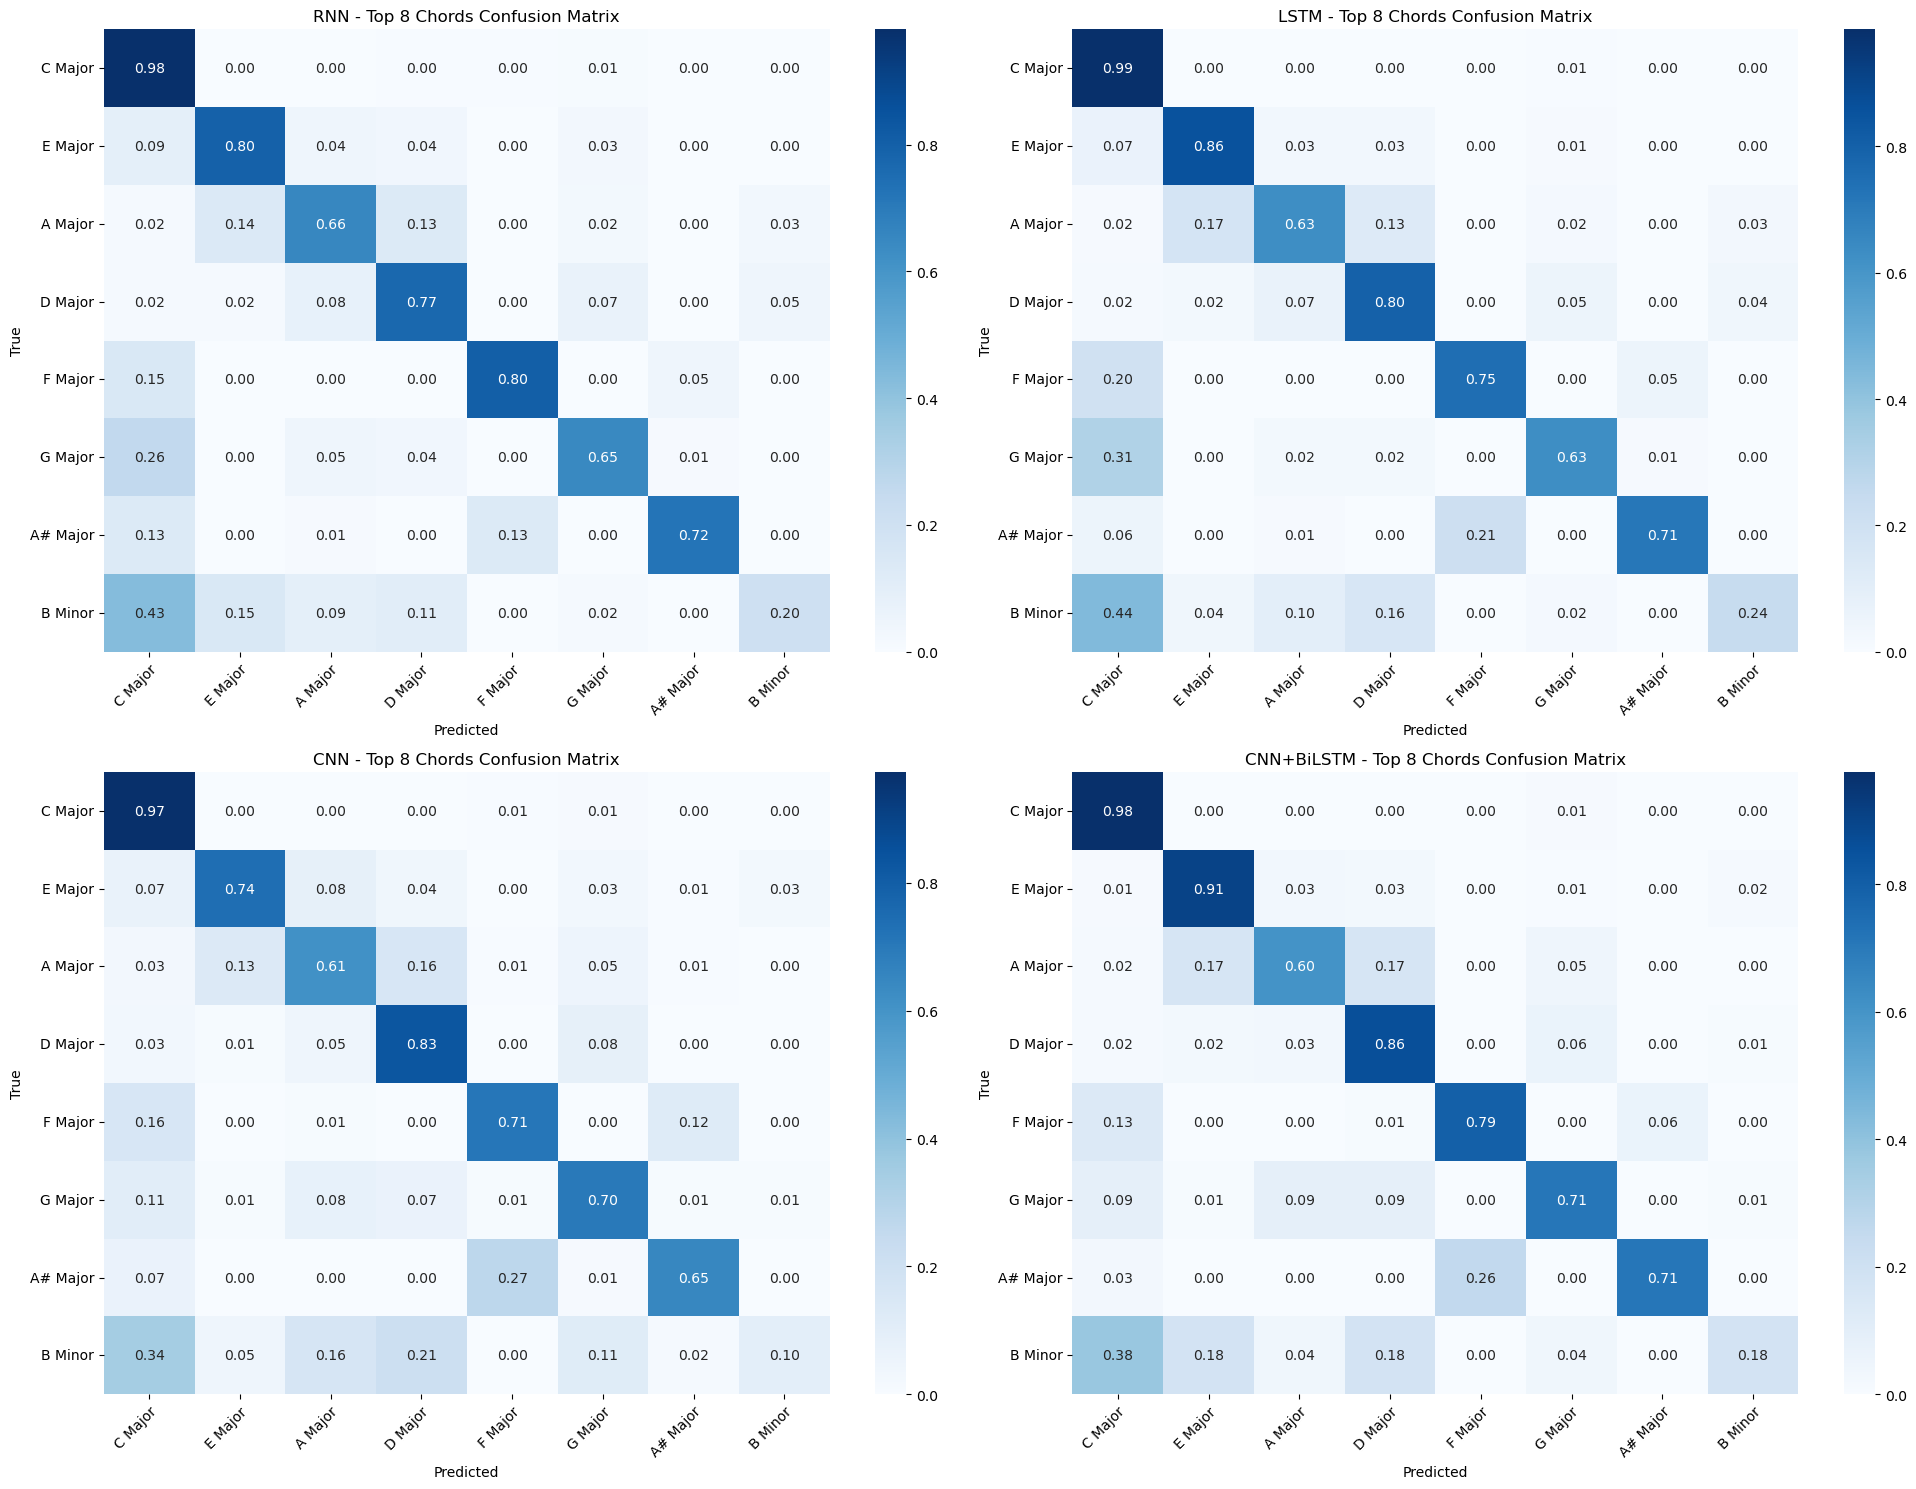

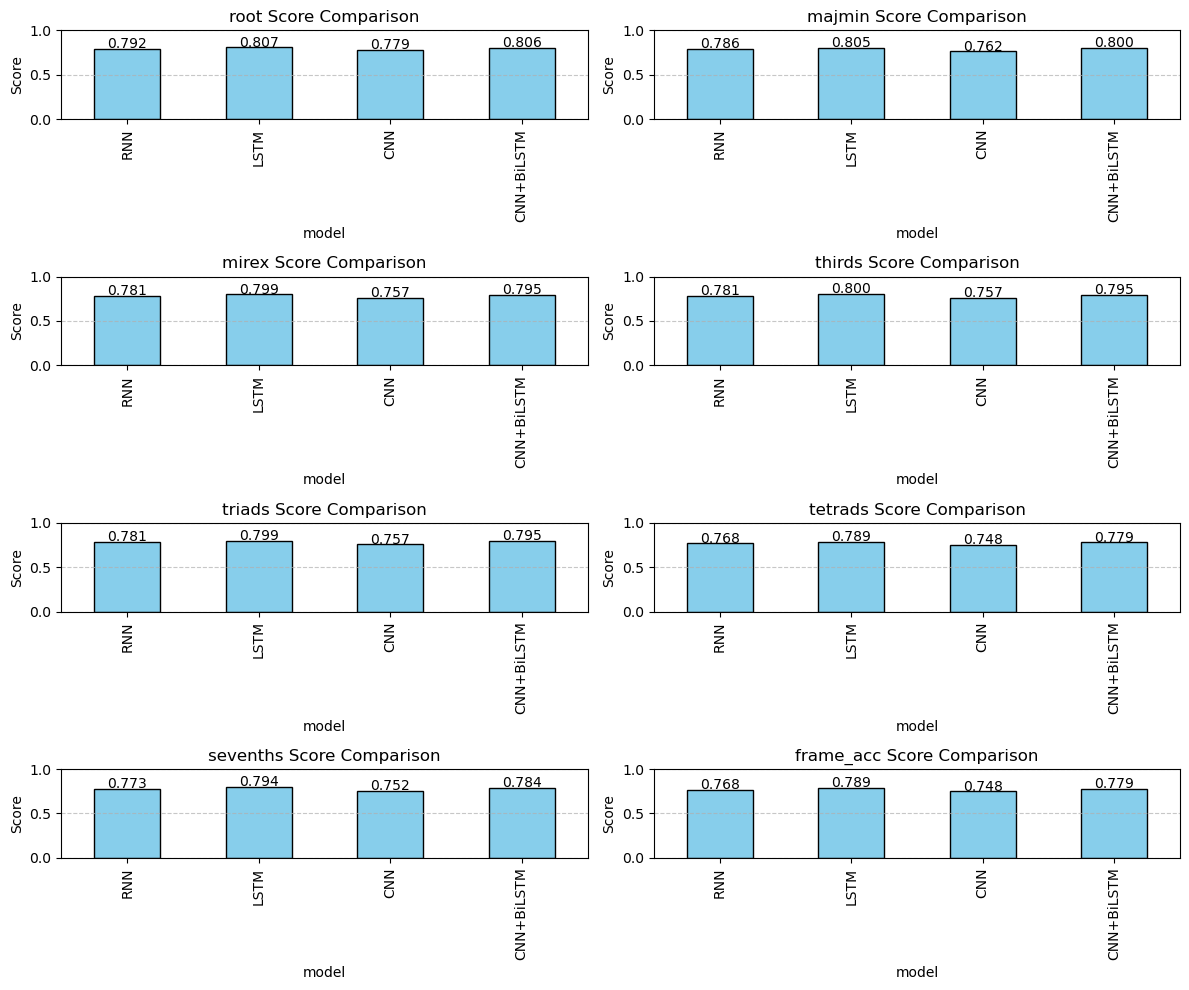

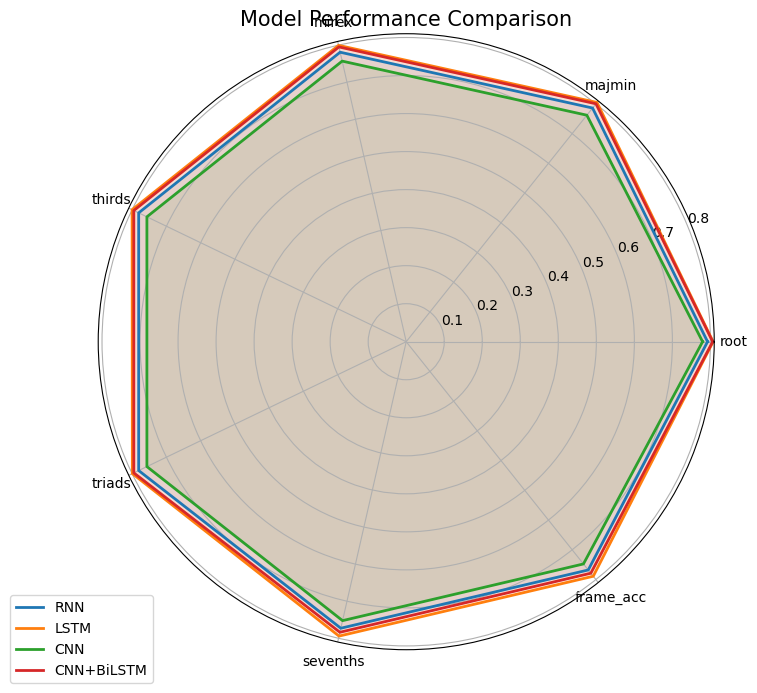

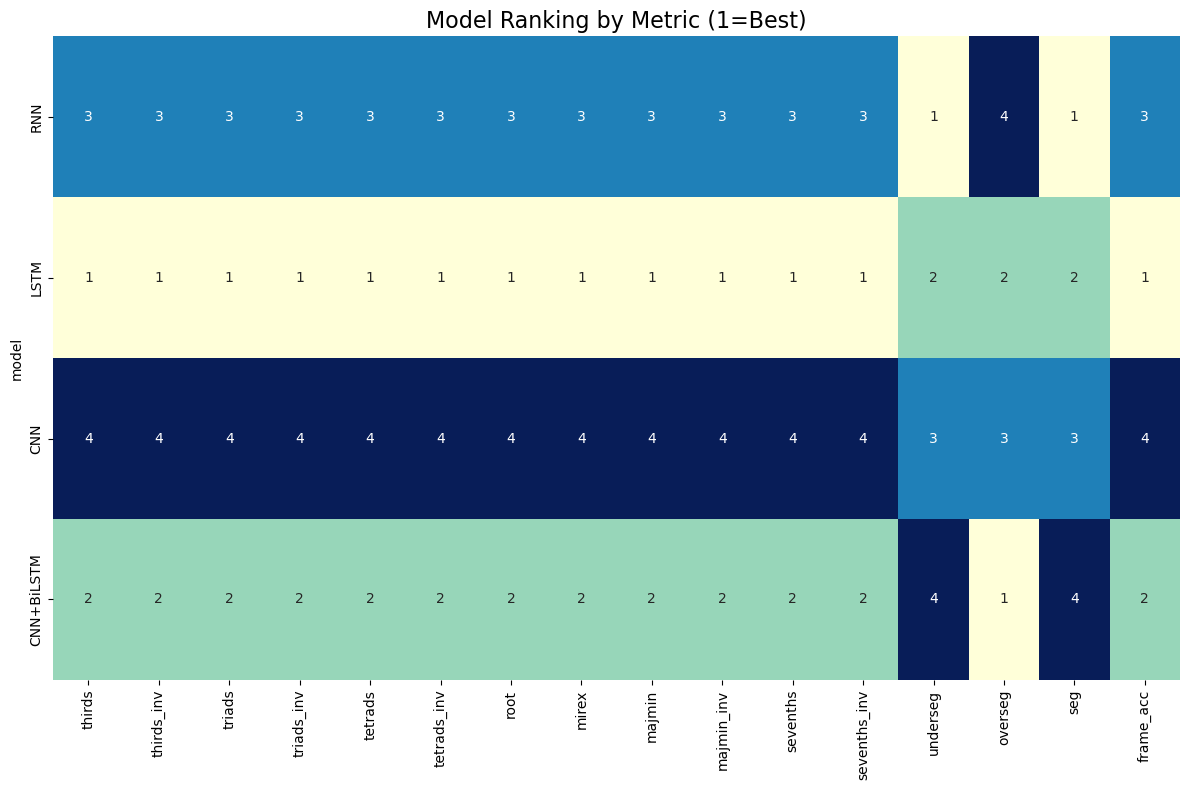

In [50]:
# show plotting

# confusion matrices
confusion_fig = plot_confusion_matrices(models, X_te, y_te, pad_id, top_n_classes=8)
plt.savefig('confusion_matrices.png', bbox_inches='tight', dpi=300)
plt.show()

# performance bar charts
performance_fig = plot_performance_comparison(df)
plt.savefig('performance_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

# radar chart for general comparison
radar_fig = plot_radar_chart(df)
plt.savefig('radar_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

# model rank by metric
def plot_model_ranks(df):
    rank_df = df.rank(ascending=False).astype(int)
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(rank_df, annot=True, cmap="YlGnBu", fmt='d', cbar=False)
    
    plt.title('Model Ranking by Metric (1=Best)', fontsize=16)
    plt.tight_layout()
    return fig

rank_fig = plot_model_ranks(df)
plt.savefig('model_rankings.png', bbox_inches='tight', dpi=300)
plt.show()